# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=7))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = float(len(data))

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = float(len(data[data.income == '>50K']))

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = float(len(data[data.income == '<=50K']))

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k/n_records)*100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222.0
Individuals making more than $50,000: 11208.0
Individuals making at most $50,000: 34014.0
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

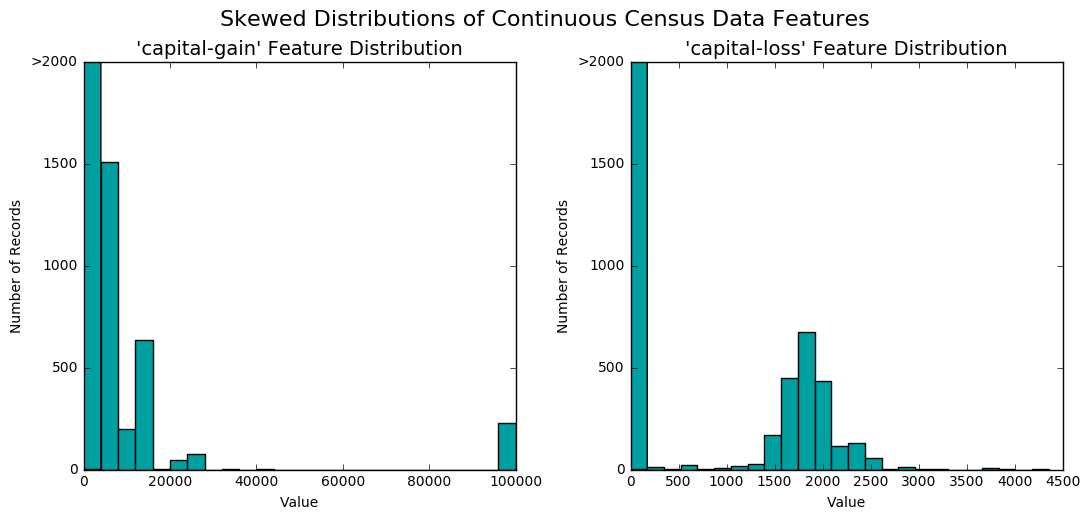

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

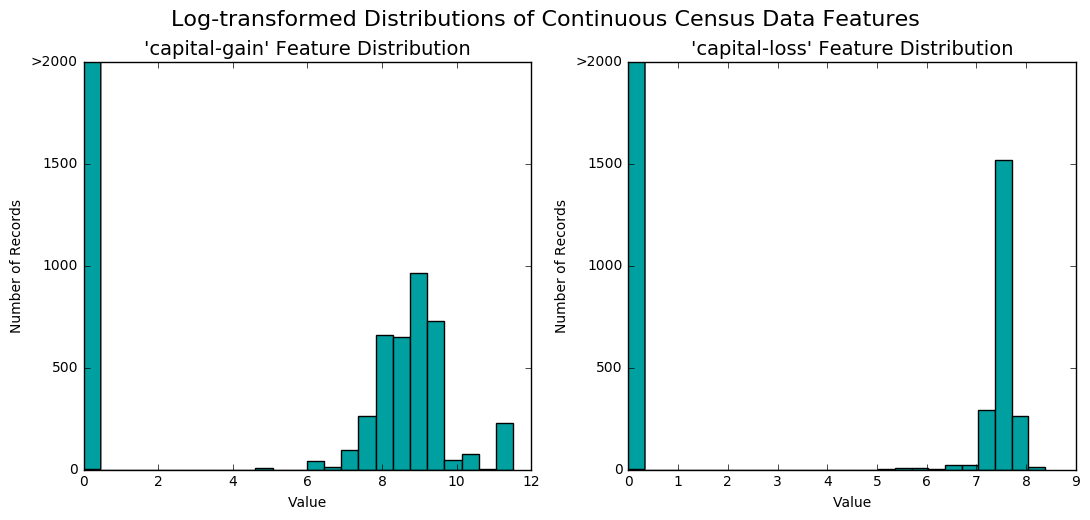

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 8))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.397959,Cuba
5,0.273973,Private,Masters,0.866667,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.00000,0.0,0.397959,United-States
6,0.438356,Private,9th,0.266667,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.00000,0.0,0.153061,Jamaica
7,0.479452,Self-emp-not-inc,HS-grad,0.533333,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.448980,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw, dummy_na=False)


# TODO: Encode the 'income_raw' data to numerical values
income = income_raw
# Manually doing the encoding to keep as a single binary variable, rather than having the two binary variables
income = income.replace('<=50K', 0)
income = income.replace('>50K', 1)
print income.head(n=8)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
Name: income, dtype: int64
103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [8]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [29]:
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import precision_score
#from sklearn.metrics import recall_score

# TODO: Number of records where individual's income is more than $50,000

#### Note: Rather than using the variables caculated previously, I am going to calculate all of these to help 
#### myself get used to reading the python language better

# precision is # of true positives divided by the total number of true positives plus false positives
precision = sum(income)/float(len(income))
# recall is # of true positives divided by the total number of true positives plus false negatives
recall = sum(income)/sum(income)


# TODO: Calculate accuracy
# Since we are predicting each individual to have income greater than fifty thousand, the accuracy will be the same as
# those who DO make over $50k divided by the total number of people predicted
accuracy = sum(income)/float(len(income))
beta = 0.5

# TODO: Calculate F-score using the formula above for beta = 0.5
fscore = (1+beta*beta)*((precision*recall)/((beta*beta*precision)+recall))
#print fscore

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

As this is a binary classification problem (1 = Above <span>$</span>50K and 0 = At most <span>$</span>50K), there are more than just three techniques above that would be applicable. I have chosen the following three and will explain why I chose each:

1.) The first model of my choice is logistic regression. I chose this model because it is a very well-known and well-used model for binary classification. One real advantage of this model is its simplicity. Because the model is so simple, understanding the output can be much easier than other predictive models. For example, the coefficients belonging to the predictor variables can be explained as a 1-1 relationship with the dependent variable, assuming all other values for the other predictors are held constant at zero. One real-world application of logistic regression would be attempting to predict whether or not a high school student will be accepted into a university.
http://www.math.montana.edu/grad/writing-projects/09sulock.pdf
Depending on the data you have, logistic regression can work very well. In comparison to some of the other models above, it can be overlooked as it does not include some of the "newer" advances of machine learning, including bagging or boosting (at least in its simplest form). Logistic regression performs well with datasets containing very few features (typically around 5-10) but could even perform well with more features on some occasions. So long as its performing well in regards to accuracy, logistic regression can be a preferred method due to its low run-time. On the other hand, datasets with many features (such as the one we are currently considering), logistic regression can run into other issues such as multi-collinearity or poor fitting due to complexity. Multi-collinearity occurs when 2 or more features are related to one another in regards to the outcome, meaning they are providing the same explanation of the dependent variable. If this occurs and is not dealt with, the output of the logistic regression can become "wonky" (quoting my old stats professor). With this particular problem, I would not recommend using logistic regression given the number of features we have, and would recommend something more complex.

2.) The second model of my choice is Random Forest. A real life example I have read about is determining what criminals will be repeat-offenders or who might commit the next crime. 
http://www-stat.wharton.upenn.edu/~berkr/Bake-Off%20copy.pdf 
I chose random forest as my next model because it has worked particularly well with identifying important variables in many models that I've had the opportunity to analyze in the healthcare industry. I've seen examples where Random Forest is used to obtain the important features in datasets with hundreds and thousands of features, and then a simpler regression model has been implemented on those that were found to be important. Many people think of Random Forest as a black box, when in fact, there are a lot of inferences on data that can be drawn from them, such as further exploring the partial dependence plots. Random Forest tends to be less accurate in classification problems than other ensemble methods including boosting regression trees or generalized boosting machines (more specifically gradient boosting). This is something I have read on Quora, but is also something that I have experienced on my own, running randomForest vs. gbm in R. There is a package called forestFloor that does a good job with visually displaying partial dependence amongst the predictors of a randomForest object, and allows us to understand the inter-relationships in regard to the outcome better. 
http://stats.stackexchange.com/questions/21152/obtaining-knowledge-from-a-random-forest 
One reason I may be interested in the model for this particular problem is the number of features we have. While gradient boosting methods also show feature importance, I have found that its good practice to compare the two methods. 
https://www.quora.com/When-is-a-random-forest-a-poor-choice-relative-to-other-algorithms

3.) With all of that being said, my overall choice of model would be the Gradient Boosting Classifier. The reason I would ultimately want to choose this model is because of the success I have seen with it first-hand. Using gbm in R, my team has been able to accurately predict individuals with a specific outcome above 90% predictive probability. Having the opportunity to be such a big part of the project is what turned me on to learning as much about machine learning as possible. So, using my experience as my reference in this instance, the strengths of using this model is its accurate predictions to unseen data. In doing this, I have noticed that the training time it takes to build our model is quite long, which is a definite downside. This model seems like a good candidate for the problem given that the data has over 100 features (after one-hot encoding) of which I do not know the inner-relationships on. Gradient boosting does a great job at dealing with multi-collinearity and variable-interaction while it uses only the features that are deemed influential. I have seen an example where there were two highly correlated variables and the model chose to use one and disregard the other, as they were explaining relatively the same thing. Most of what I know about random forest and generalized boosting methods were from cran.r-project.org and Cross Validated on stack exchange.



### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [30]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    # Defining Beta
    beta = 0.5
    
    # Creating the step size for slicing in terms of the sample size
    step = len(y_train)/int(sample_size)
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[::step], y_train[::step])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = round(end-start,2) # Seconds to the 2nd decimal
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = round(end-start,2)
            
    # TODO: Compute accuracy on the first 300 training samples
    
    results['acc_train'] = accuracy_score(predictions_train,y_train[:300])
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(predictions_test,y_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta = beta)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,beta = beta)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
clf = LogisticRegression()
train_predict(clf, 100, X_train, y_train, X_test, y_test)


LogisticRegression trained on 100 samples.


{'acc_test': 0.8231066887783306,
 'acc_train': 0.81000000000000005,
 'f_test': 0.64157927205428744,
 'f_train': 0.59615384615384615,
 'pred_time': 0.05,
 'train_time': 0.08}

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

LogisticRegression trained on 362.0 samples.
LogisticRegression trained on 3618.0 samples.
LogisticRegression trained on 36177.0 samples.
RandomForestClassifier trained on 362.0 samples.
RandomForestClassifier trained on 3618.0 samples.
RandomForestClassifier trained on 36177.0 samples.
GradientBoostingClassifier trained on 362.0 samples.
GradientBoostingClassifier trained on 3618.0 samples.
GradientBoostingClassifier trained on 36177.0 samples.


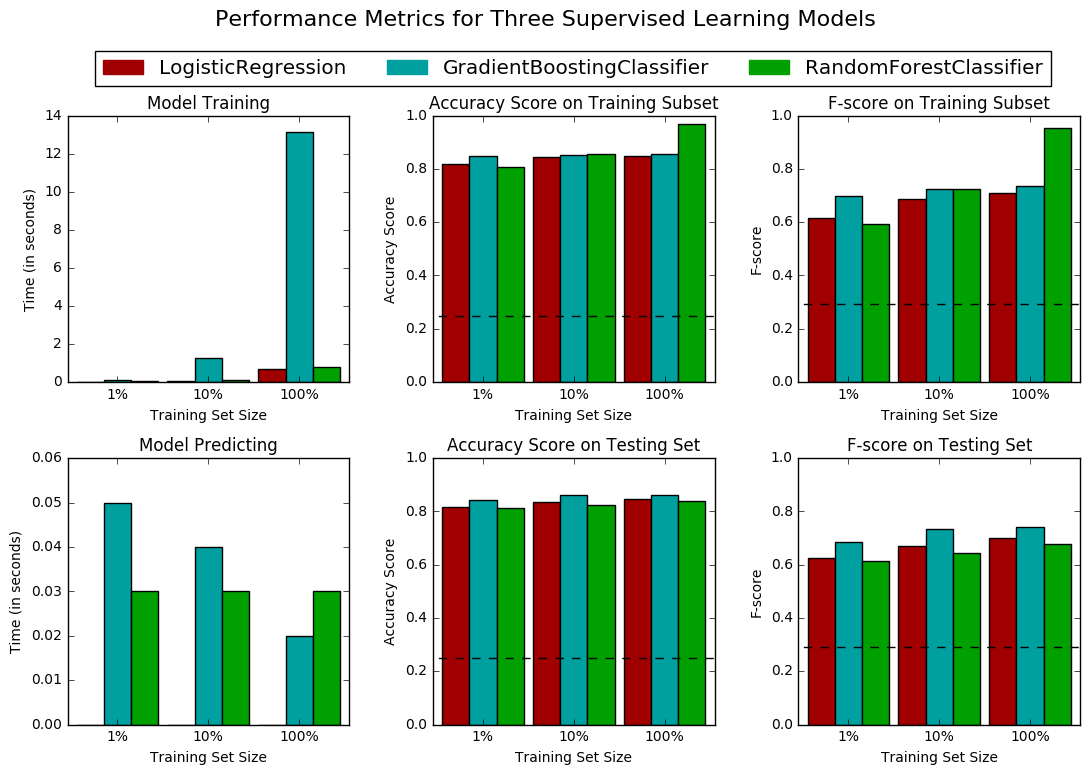

In [31]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# TODO: Initialize the three models
clf_A = LogisticRegression(random_state = 7)
clf_B = RandomForestClassifier(random_state = 7)
clf_C = GradientBoostingClassifier(random_state = 7)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = round(0.01*len(X_train))
samples_10 = round(0.1*len(X_train))
samples_100 = round(len(X_train))


# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

Of the three models I chose to run, I believe that the GradientBoostingClassifier would be the best option. Although this model took the longest to train, at a little over 20 seconds for 100<span>%</span> of the data, the training time still wasn't long enough to rule it out. Since we really are hoping to identify individuals who make over <span>$</span>50k, we should focus our attention on the accuracy of the classification.

Regardless of the training set size, the GradientBoostingClassifier outperformed logistic regression and random forest in terms of accuracy. By this I mean that the proportion of individuals who are correctly classified as having the desired income of all individuals classified is larger for our chosen model at each training set size used. This also holds true with the F-score on the testing set. The reason this is even more important is because the F-score is showing just how precise we are. In other words, the GradientBoostingClassifier finds more individuals who make over <span>$</span>50k than the other two models (of all individuals who could potentially have been identified), while still keeping into consideration the number of false positives. 

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

For us to use the GradientBoostingClassifier, it will take at most half of a minute to prepare for us to make a prediction. Once we are ready, we will apply our classifier to new individuals and predict those who will make more than \$50k. There will be some individuals who are incorrectly identified, but by using this model, we are limiting this portion to less than 20<span>%</span> of all identified individuals. So, if we are able to identify 1,000 individuals, we should expect that over 800 of them will make over \$50k. This will be done with precision as well, meaning that if there were only about 1,100 individuals who make over \$50k, we would expect to identify roughly 825 of them (~75<span>%</span>).

How the Gradient Boosting (GB) Classifier will work is it will start by fitting a decision tree-based model on the training data set and then use this model to classify each individual as either having an income higher than \$50k or at most \$50k by optimizing a logarithmic loss function (will be further-explained later). From there, the GB will assess which individuals' incomes were incorrectly classified based on the generalization. Next, the model will iterate this process again, adding more weight on those who were incorrectly classified, hoping to correctly classify them this next time around. Again, GB will repeat this process until we reach our maximum number of iterations that we established before-hand. 

While GB is constantly adding more weight on incorrectly identified individuals, it is minimizing the deviance, or the error attributed by our fit using a differentiable loss-function (a smooth function that has a non-vertical tangent line at each point in its domain - see https://en.wikipedia.org/wiki/Differentiable_function). In this case, the deviance through logistic regression is our loss function as it pertains to binary classification and depending on the problem, other loss functions may be used. 

This iterative process also utilizes the concept of a weak learner, or a classifier that will always do better than by chance. The classifier will generalize on unseen data to make predictions by fitting the final model after all iterations have been made. A good way to think about this is to visualize a decision tree where the output of our model classifies individuals by each feature that describes them. For example, maybe the first split in our decision tree is whether an individual works 40 or more hours per week or not. For those who work at least 40 hours per week, maybe they are classified with a higher probability of having an income of at least \$50k vs. those who don't work at least 40 hours per week. Since each individual will have follow the tree until there is a classification made, we will be able to see how accurately they are all predicted, and as stated earlier, we would expect to accurately predict over 80% of the individuals.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [35]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import GradientBoostingClassifier

# TODO: Initialize the classifier
clf = GradientBoostingClassifier(random_state = 7)

# TODO: Create the parameters list you wish to tune
#parameters = {'max_depth' : [3,4,5]}  
parameters = {'n_estimators' : [100,500,1000]} # This parameter has a better improvement in accuracy

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)


# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8718
Final F-score on the testing data: 0.7545


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |       24.78%        |      83.60%       |      87.18%     |
| F-score        |       29.17%        |      73.95%       |      75.45%     |


Our optimized model's accuracy represents that nearly 9 out of 10 individuals who are classified actually make more than \$50k. This is much better than our unoptimized model of 83.6<span>%</span> accuracy, and immensely better than our Naive predictor of only 24.78<span>%</span>.  The F-score expresses a 1.5<span>%</span> increase for our optimized model as opposed to our unoptimized model, which describes that our precision is more optimal as well. The comparison to our Naive predictor shows yet another impressive increase.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

The following 5 features are what I would believe to be the most important for the prediction:

1.) education-num <br/>
2.) capital-gain <br/>
3.) hours-per-week <br/>
4.) sex <br/>
5.) race <br/>

and here is why - 

I chose education-num as the most important because it represents the level of education the individual has as a numerical value. I would assume those who have a higher education-num value would be most likely to be making more money, given that they have a higher education. The second most important feature I chose is capital-gain, because it is representing a subset of their actual income based off of investments, which I assume would be indicative of someone's overall income. The third feature I chose is hours-per-week. The reason I chose hours-per-week is because, given that an individual is not a salaried employee at their occupation, the more hours they are making the more income they would ultimately be taking home. The fourth feature I chose is sex. The reason I chose sex is based more off of my memory of hearing statistics stating that men make more money than women, and so I am assuming that if the individual is male then they are more likely to have a higher income. The fifth feature I chose was race. Just like the negative stereotype that may have brough sex to my list of top five features, I recall hearing statistics at some point in my past indicating that minorities make less money than white people.



### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

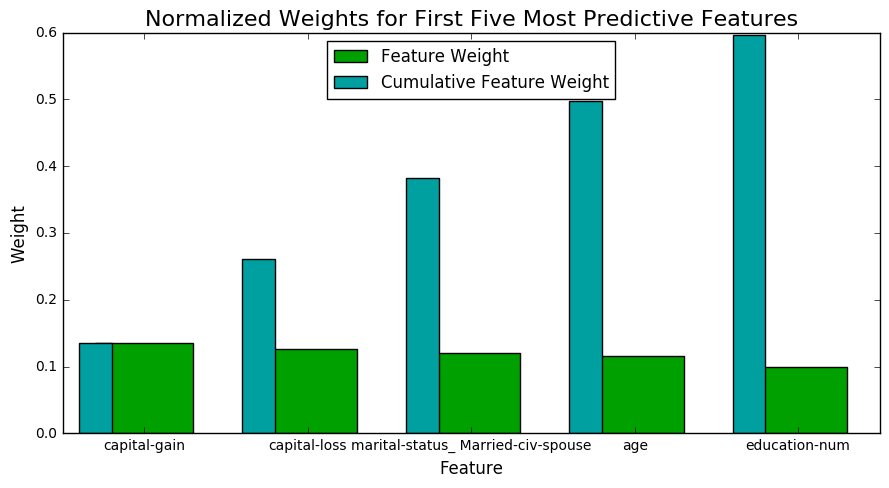

In [54]:
# TODO: Import a supervised learning model that has 'feature_importances_'
clf = GradientBoostingClassifier(random_state = 7)

# TODO: Train the supervised model on the training set 
model = clf.fit(X_train, y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

The output from the GradientBoostingClassifier show that the following five features are the most important in predicting the outcome (starting with the fifth most important):

5.) education-num <br/>
4.) age <br/>
3.) marital-status_Married-civ-spouse <br/>
2.) capital-loss <br/>
1.) capital-gain <br/>

I only guessed 2 out of the top 5 features, however, I'm not surprised at what the top five were. I'm a little surprised with  education-num being the fifth most important variable as I guessed it to be the first most important, but am not surprised that its on the list for the reasons I described previously. I'm also not surprised that age is on the list (though I am surprised I overlooked it to begin with!). It would make sense that someone who is older would make more money than, say someone right out of college or highschool. Again, I'm not surprised that being married is on the list. I assume that if someone is married, then they are more likely to be financially stable and thus make more money. Capital loss is also not surprising as it represents something similar to that of capital gain, just in the opposite direction. It is very sensible to assume that someone with a larger capital loss is less likely to have made more money. Lastly, capital gain makes sense for the same reasons I listed previously. The visualization confirms the order as well as the magnitude of the order by showing me that the cumulzative weights increase dramatically as we reach our fifth most important feature.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [55]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8697
F-score on testing data: 0.7503

Final Model trained on reduced data
------
Accuracy on testing data: 0.8584
F-score on testing data: 0.7243


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

The accuracy score was only reduced by a single percentage point whereas the F-score was reduced by about two and a half percentage points. These reductions are enough to choose the model trained on full data as we are currently looking at things, however, if training time was a factor then this would easily change. These reductions aren't big enough to sacrifice a lot of training time when we could easily get a near-optimal accuracy rate and F-score.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.